# Synthetic Data Pairs

In [1]:
include("src/Misc.jl");

In [2]:
using .Misc
import .Misc: generate_params

In [3]:
using Statistics, Distributions
using SpecialFunctions, LinearAlgebra
import Random: randperm, seed!
import Printf: @sprintf

using PyPlot
seed!(8457);

In [4]:
MARKER = ["o", "v", "d", "X", "p", "*", "P"];
RESULTS_PATH = "./results/synthetic/smc/all";
PARAMS_PATH = "./params";
DATA_PATH = "./data/synthetic";

N_PARAMS = 36

36

In [5]:
function accuracy(models,g_truth; weights=ones(length(models)))
    return sum((models .== g_truth) .* weights) / sum(weights)
end

accuracy (generic function with 1 method)

In [6]:
function spurious_pairs(models)
    return valid_pairs[(models .== 3)[:,1]]
end

spurious_pairs (generic function with 1 method)

In [7]:
T, Rs = 2000, 1:5
REPEAT = 1

N_DATA = length(Rs)*N_PARAMS*REPEAT*3

540

## Generate Data

In [8]:
function generate_params(A₁,A₂,B₁,B₂)
    num = 0
    for a₁ ∈ A₁, a₂ ∈ A₂, b₁ ∈ B₁, b₂ ∈ B₂
        if a₁ >= b₁ && a₂ >= b₂
                num += 1
                setup = Dict(:name => "params-$num", :P => 100, :Rs => 1:5, :M => 2, 
                             :γ => 10.0, :m₁ => 0.0, :m₂ => 0.0, :λ₁ => 0.1, 
                             :λ₂ => 0.1, :a₁ => a₁, :a₂ => a₂, :b₁ => b₁, :b₂ => b₂);
                save_json("$PARAMS_PATH/params-$num.json"; setup...)
        end
    end
    return num
end

generate_params (generic function with 1 method)

In [9]:
function generate_data(T::Int, R::Int; K=2, α=10.0, m₁=0.0, m₂=0.0,
        λ₁=0.1, λ₂=0.1, a₁=1.0, a₂=1.0, b₁=1.0, b₂=1.0, pr=0, rel="^", id=0)
    
    if rel=="^"
        K, a₂, b₂ = 1, a₁, b₁
    end
    
    θ = rand(Dirichlet(R,α))
    ρ₁, ρ₂ = rand(Gamma(a₁,1/b₁),R), rand(Gamma(a₂,1/b₂),R)
    μ₁ = [rand(Normal(m₁, (λ₁ * ρ₁[r])^(-1/2))) for r ∈ 1:R]
    w₂ = [rand(MultivariateNormal(m₂*ones(K), Diagonal(ones(K)/(λ₂*ρ₂[r])))) for r ∈ 1:R]
    
    rs = rand(Categorical(θ),T)
    X₁ = [rand(Normal(μ₁[r], ρ₁[r]^(-1/2))) for r ∈ rs]
    X₂ = [rand(Normal(w₂[r]'*(X₁[t].^(0:K-1)), ρ₂[r]^(-1/2))) for (t,r) ∈ enumerate(rs)]
    
    X = rel=="<-" ? X₂ : X₁
    Y = rel=="<-" ? X₁ : X₂
    
    pair = Dict(:X_label => "X", :Y_label => "Y", :dataset => pr, :weight => 1.0,
                :id => "syth-$id", :relationship => rel, :X => X, :Y => Y)
    save_json("$DATA_PATH/synt-$id.json"; pair...)
    
    return pair
end

generate_data (generic function with 1 method)

In [10]:
T, Rs = 2000, 1:5

(2000, 1:5)

In [11]:
N_PARAMS = generate_params(10.0.^(0:2), 10.0.^(0:2), 10.0.^(0:2), 10.0.^(0:2))

params = [Dict(Symbol(String(p)) => v for (p,v) ∈ load_json("$PARAMS_PATH/params-$n.json"))
                                      for n ∈ 1:N_PARAMS];

In [12]:
N_DATA = 0
for rep ∈ 1:1, R ∈ Rs, pr ∈ 1:N_PARAMS, rel ∈ ["->", "<-", "^"]
    N_DATA += 1
    a₁, a₂, b₁, b₂ = params[pr][:a₁], params[pr][:a₂], params[pr][:b₁], params[pr][:b₂]
    generate_data(T, R; pr=pr, rel=rel, id=N_DATA, a₁=a₁, a₂=a₂, b₁=b₁, b₂=b₂)
end

In [13]:
N_DATA

540

## Read Results

In [14]:
params = [Dict(Symbol(String(p)) => v for (p,v) ∈ load_json("$PARAMS_PATH/params-$pr.json"))
                                      for pr ∈ 1:N_PARAMS]

synt_data = [Dict(Symbol(String(p)) => v for (p,v) ∈ load_json("$DATA_PATH/synt-$id.json")) 
                                    for id ∈ 1:N_DATA];

In [15]:
results = zeros(REPEAT,length(Rs),N_PARAMS,3,3,length(Rs))
ground_truth = zeros(Int,REPEAT,length(Rs),N_PARAMS,3)
weights = zeros(REPEAT,length(Rs),N_PARAMS,3)

id = 0
for rep ∈ 1:REPEAT, R ∈ Rs, pr ∈ 1:N_PARAMS, rel ∈ 1:3
    id += 1
    result = hcat(load_json("$RESULTS_PATH/$(synt_data[id][:id]).json")["scores"]...)
    results[rep,R,pr,rel,:,:] .= result
    
    pair = synt_data[id]
    ground_truth[rep,R,pr,rel] = pair[:relationship] == "->" ? 1 : (pair[:relationship] == "<-" ? 2 : 3)
    weights[rep,R,pr,rel] = pair[:weight]
end

In [16]:
labels_all = [findmax(nanmax(results[rep,R,pr,rel,:,:],2))[2] 
              for rep ∈ 1:REPEAT, R ∈ Rs, pr ∈ 1:N_PARAMS, rel ∈ 1:3];

In [17]:
accuracy(labels_all,ground_truth; weights=weights)

0.9851851851851852

## Accuracy w.r.t Ground Truth

In [18]:
import Seaborn: heatmap

In [19]:
confusion_matrix = zeros(Int,3,3)

for rel ∈ 1:3, p ∈ 1:N_PARAMS, R ∈ 1:5
    confusion_matrix[rel,findmax(nanmax(results[1,R,p,rel,:,:],2))[2]] +=1
end

confusion_matrix

3×3 Array{Int64,2}:
 177    3    0
   5  175    0
   0    0  180

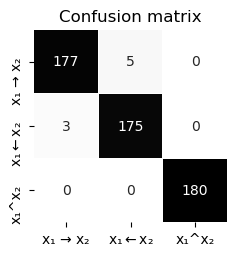

In [20]:
PyPlot.figure(figsize=(2.5,2.5))
PyPlot.title("Confusion matrix")
PyPlot.xlabel("True Model")
PyPlot.ylabel("Predicted Model")
heatmap(confusion_matrix'; xticklabels=["x₁ \$\\to\$ x₂", "x₁\$\\leftarrow\$x₂", "x₁^x₂"],
    yticklabels=["x₁ \$\\to\$ x₂", "x₁\$\\leftarrow\$x₂", "x₁^x₂"], annot=true, cmap="gray_r",
    linecolor="w", linewidth=0.01, fmt="d", cbar=false
)

PyPlot.savefig("./img/confusion_matrix.pdf", bbox_inches="tight");

In [21]:
[accuracy(labels_all[:,:,:,rel],ground_truth[:,:,:,rel]; weights=weights[:,:,:,rel]) for rel ∈ 1:3]

3-element Array{Float64,1}:
 0.9833333333333333
 0.9722222222222222
 1.0               

# ROC

In [22]:
AUCs = zeros(3)

for lb ∈ 1:3
    score = nanmax(results[:,:,:,:,lb,:],5) .- nanmax(results[:,:,:,:,setdiff(1:3,[lb]),:],dims=(5,6))
    AUCs[lb] = AUC(score, ground_truth, lb; weights=weights)
end

In [23]:
AUCs

3-element Array{Float64,1}:
 0.9993518518518518
 0.9994135802469135
 1.0               

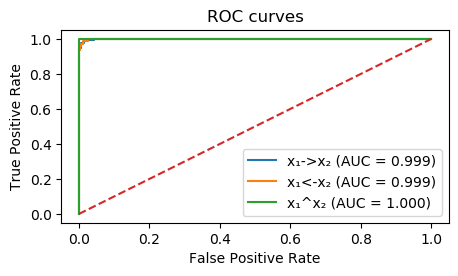

In [24]:
PyPlot.figure(figsize=(5,2.5))
PyPlot.title("ROC curves")
PyPlot.ylabel("True Positive Rate")
PyPlot.xlabel("False Positive Rate")
for (lb, dr) ∈ enumerate(["x₁->x₂", "x₁<-x₂", "x₁^x₂"])
    score = nanmax(results[:,:,:,:,lb,:],5) .- nanmax(results[:,:,:,:,setdiff(1:3,[lb]),:],dims=(5,6))
    PyPlot.plot(ROC(score, ground_truth, lb; weights=weights)...;label="$dr (AUC = $(@sprintf("%.3f", AUCs[lb])))")
end
PyPlot.plot([0,1],[0,1];linestyle=:dashed)
PyPlot.legend()

PyPlot.savefig("./img/roc_curve.pdf", bbox_inches="tight");